# Analyze DBTL1 proteomics

For DBTL1, we produced 2- and 3-gRNA P.Putida strains and did global proteomics. Here we analyze the proteomics data in order to filter strains by dCas9 expression and target inhibition.

## Input and output

## 1. Setup

### 1.1 Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

Define function for identifying if tests pass throughout the workbook: 

### 1.2 User parameters

In [2]:
user_params = {
    'output_dir'  : './dtbl1_figures_and_analysis/',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
}

### 1.3 Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [3]:
study_slug_1 = 'crispri-automation-for-enhanced-isoprenol-pro-fca3'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'

We try connecting to the server with our login and password:

In [4]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [5]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

  0%|          | 0/475488 [00:00<?, ?it/s]

There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [6]:
df['Protocol'].unique()

array(['GC-FID', 'Global Proteomics', 'Biolector'], dtype=object)

## 2. Preprocess and inspect data

### 2.1 Useful functions - preprocessing

In [7]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

### 2.2 Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [8]:
df

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,191107,CRISPRi automation for enhanced isoprenol prod...,191108,5ccffc96-15ea-4e75-89cc-e198de3bab69,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,191300,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,48.00000
1,191107,CRISPRi automation for enhanced isoprenol prod...,191109,82a2ac64-9ac2-46db-a26d-0325b57e876e,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,191301,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,48.00000
2,191107,CRISPRi automation for enhanced isoprenol prod...,191110,620d107d-a643-4f69-82ae-a11916dfda58,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,191302,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,48.00000
3,191107,CRISPRi automation for enhanced isoprenol prod...,191111,22e396ed-81f5-450c-a279-edb237b08008,PP_3123_PP_4862_PP_5186-R1,DBTL1_P1_004,GC-FID,191303,PP_3123_PP_4862_PP_5186-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,165.8082,48.00000
4,191107,CRISPRi automation for enhanced isoprenol prod...,191112,ebb85028-ca43-4492-8d70-df4ad3cbc762,PP_2137_PP_4116_PP_4187-R1,DBTL1_P1_005,GC-FID,191304,PP_2137_PP_4116_PP_4187-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,222.7008,48.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475483,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.4600,47.34472
475484,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.2800,47.51139
475485,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.0400,47.67806
475486,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,15.8700,47.84472


In [9]:
df['Protocol']=='Biolector'

0         False
1         False
2         False
3         False
4         False
          ...  
475483     True
475484     True
475485     True
475486     True
475487     True
Name: Protocol, Length: 475488, dtype: bool

In [10]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [11]:
df2.shape

(420096, 15)

Let's just keep the basic data types:

In [12]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [13]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(144,
 array(['DBTL1_P1_001', 'DBTL1_P1_002', 'DBTL1_P1_003', 'DBTL1_P1_004',
        'DBTL1_P1_005', 'DBTL1_P1_006', 'DBTL1_P1_007', 'DBTL1_P1_008',
        'DBTL1_P1_009', 'DBTL1_P1_010', 'DBTL1_P1_011', 'DBTL1_P1_012',
        'DBTL1_P1_013', 'DBTL1_P1_014', 'DBTL1_P1_015', 'DBTL1_P1_016',
        'DBTL1_P1_017', 'DBTL1_P1_018', 'DBTL1_P1_019', 'DBTL1_P1_020',
        'DBTL1_P1_021', 'DBTL1_P1_022', 'DBTL1_P1_023', 'DBTL1_P1_024',
        'DBTL1_P1_025', 'DBTL1_P1_026', 'DBTL1_P1_027', 'DBTL1_P1_028',
        'DBTL1_P1_029', 'DBTL1_P1_030', 'DBTL1_P1_031', 'DBTL1_P1_032',
        'DBTL1_P1_033', 'DBTL1_P1_034', 'DBTL1_P1_035', 'DBTL1_P1_036',
        'DBTL1_P1_037', 'DBTL1_P1_038', 'DBTL1_P1_039', 'DBTL1_P1_040',
        'DBTL1_P1_041', 'DBTL1_P1_042', 'DBTL1_P1_043', 'DBTL1_P1_044',
        'DBTL1_P1_045', 'DBTL1_P1_046', 'DBTL1_P1_047', 'DBTL1_P1_048',
        'DBTL1_P3_048', 'DBTL1_P3_049', 'DBTL1_P3_050', 'DBTL1_P3_051',
        'DBTL1_P3_052', 'DBTL1_P3_053', 'DBTL1_P3_054', 'D

In [14]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(192,
 array(['PP_0226_PP_0897_PP_5288-R1', 'PP_1319_PP_1457_PP_4192-R1',
        'PP_2213_PP_2471_PP_4266-R1', 'PP_3123_PP_4862_PP_5186-R1',
        'PP_2137_PP_4116_PP_4187-R1', 'PP_4189_PP_4550_PP_4862-R1',
        'PP_0813_PP_1769_PP_4191-R1', 'PP_0368_PP_4191_PP_4192-R1',
        'PP_0226_PP_0897_PP_5288-R2', 'PP_1319_PP_1457_PP_4192-R2',
        'PP_2213_PP_2471_PP_4266-R2', 'PP_3123_PP_4862_PP_5186-R2',
        'PP_2137_PP_4116_PP_4187-R2', 'PP_4189_PP_4550_PP_4862-R2',
        'PP_0813_PP_1769_PP_4191-R2', 'PP_0368_PP_4191_PP_4192-R2',
        'PP_0226_PP_0897_PP_5288-R3', 'PP_1319_PP_1457_PP_4192-R3',
        'PP_2213_PP_2471_PP_4266-R3', 'PP_3123_PP_4862_PP_5186-R3',
        'PP_2137_PP_4116_PP_4187-R3', 'PP_4189_PP_4550_PP_4862-R3',
        'PP_0813_PP_1769_PP_4191-R3', 'PP_0368_PP_4191_PP_4192-R3',
        'PP_0751_PP_1620_PP_4678-R1', 'PP_0813_PP_4549_PP_5288-R1',
        'PP_2112_PP_2136_PP_4678-R1', 'PP_0368_PP_0812_PP_0944-R1',
        'PP_0999_PP_3578_PP_5186-R1', 'PP_

In [15]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|A9GAJ9|A9GAJ9_SORC5 Mcm', 'sp|O77727', ...,
       'sp|Q9FD71|HMGCS_ENTFL', 'sp|Q9NSB2', 'sp|Q9Z408|CSD_PSEPK Csda'],
      dtype=object)

In [16]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [17]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

### 2.2 Add strain name to dataframe using prebuilt function.

In [18]:
df2["Strain"] = create_strain_names(df2)
print(df2.shape)

(420096, 7)


### 2.3 Bring out Uniprot names

In [19]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)
get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'
print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


In [20]:
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
0,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,173.9811,P1
1,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,268.6526,P1
2,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,182.8489,P1
3,PP_3123_PP_4862_PP_5186-R1,DBTL1_P1_004,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,165.8082,P1
4,PP_2137_PP_4116_PP_4187-R1,DBTL1_P1_005,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,222.7008,P1


In [21]:
print(df2.shape)

(420096, 7)


### 2.4 Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [22]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()

,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [23]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

#### 2.4.1 Protein-gene mapping sanity check
Need to check: is there a 1 to 1 correspondence between target genes and uniprot IDs?

There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [24]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets show up multiple times in the uniprot list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times in the target list')
print(upid_value_counts[upid_value_counts>1])


In the Protein Mapping spreadsheet, there are 123 unique target genes and 122 unique uniprot IDs
These targets show up multiple times in the uniprot list:
CRISPRi target gene
PP_1607    10
PP_0528     3
PP_0548     3
PP_4679     3
PP_4194     2
Name: count, dtype: int64
These Uniprot IDs show up multiple times in the target list
UNIPROT ID
Q88MG4    10
Q88DY9     3
Q88QG6     3
Q88QE6     3
Q88FA4     2
Q877U6     2
Name: count, dtype: int64


### 2.5 Drop non-target proteins

Add dCas9 to the Protein mapping dataframe

In [25]:
ProtMapping_df.loc[len(ProtMapping_df), ['CRISPRi target gene', 'UNIPROT ID']] = 'dCas9', 'Q99ZW2'

Make list of proteins

In [26]:
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()

We want to keep dCas9, so add it ot the list.

In [27]:
targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
df2 = df2.drop(
                    index=df2[(~df2['Formal Type'].isin(targets_in_mapping)) &
                                  (df2['Protocol']=='Global Proteomics')].index)
print(df2.shape)

(19392, 7)


In [28]:
len(targets_in_mapping)

123

### 2.6 Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [29]:
uniprot_to_pp = {}
for index in ProtMapping_df.index:
    uniprot_to_pp[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

Do the translation:

In [30]:
proteomics_ind = df2['Protocol']=='Global Proteomics'
df2.loc[proteomics_ind,'Formal Type'] = df2.loc[proteomics_ind,'Formal Type'].apply(lambda x: uniprot_to_pp[x])

### 2.7 Add Target Gene
Add column with a target gene for each strain.

In [31]:
# get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
# get_target_gene_teststring = 'PP_4549-R1'
# print(f'To get target gene:\n Input string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

In [32]:
# df2['Target'] = df2['Line Name'].apply(get_target_gene)
# df2.head()

In [33]:
df2['Formal Type'].unique()

array(['cid:12988', 'PP_2471', 'PP_1506', 'PP_0001', 'PP_3365', 'PP_5419',
       'PP_5417', 'PP_5416', 'PP_5335', 'PP_5288', 'PP_5203', 'PP_5186',
       'PP_5128', 'PP_5064', 'PP_4894', 'PP_4862', 'PP_4702', 'PP_4679',
       'PP_4678', 'PP_4667', 'PP_4651', 'PP_4650', 'PP_4636', 'PP_4635',
       'PP_4549', 'PP_4487', 'PP_4266', 'PP_4194', 'PP_4193', 'PP_4192',
       'PP_4191', 'PP_4190', 'PP_4189', 'PP_4188', 'PP_4187', 'PP_4186',
       'PP_4185', 'PP_4175', 'PP_4174', 'PP_4130', 'PP_4129', 'PP_4128',
       'PP_4123', 'PP_4122', 'PP_4121', 'PP_4120', 'PP_4119', 'PP_4116',
       'PP_4012', 'PP_4011', 'PP_3755', 'PP_3754', 'PP_3578', 'PP_3123',
       'PP_3122', 'PP_3071', 'PP_2925', 'PP_2339', 'PP_2137', 'PP_2136',
       'PP_2112', 'PP_2095', 'PP_1777', 'PP_1770', 'PP_1769', 'PP_1755',
       'PP_1664', 'PP_1620', 'PP_1610', 'PP_1607', 'PP_1457', 'PP_1444',
       'PP_1319', 'PP_1318', 'PP_1317', 'PP_1251', 'PP_1240', 'PP_1031',
       'PP_1023', 'PP_0999', 'PP_0944', 'PP_0897'

In [34]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
0,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.739811e+02,P1
1,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.686526e+02,P1
2,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.828489e+02,P1
3,PP_3123_PP_4862_PP_5186-R1,DBTL1_P1_004,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.658082e+02,P1
4,PP_2137_PP_4116_PP_4187-R1,DBTL1_P1_005,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.227008e+02,P1
...,...,...,...,...,...,...,...
419707,PP_0814_PP_3123-R2,DBTL1_P3_062,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,8.874419e+06,P3
419708,PP_0814_PP_3123-R3,DBTL1_P3_070,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,1.088618e+07,P3
419709,PP_0814_PP_4192-R4,DBTL1_P1_031,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,2.044419e+06,P1
419710,PP_0814_PP_4192-R5,DBTL1_P1_039,Global Proteomics,dCas9,CRISPR-associated endonuclease Cas9/Csn1,1.694971e+06,P1


## 3. Format data to look at dCas9 and target expression vs controls

### 3.1 Add correct control value to each row in dataframe

In [35]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control).astype(bool)

In [36]:
control_mean_df = df2[df2['Control']]
control_mean_df = control_mean_df[['Formal Type', 'Value']].groupby('Formal Type').mean()
# control_mean_df.reset_index(drop = True)
# df2['Line Name'].unique()
control_mean_df.loc['PP_0001', 'Value']

2354989.0900000003

In [37]:
add_control_value = lambda x: control_mean_df.loc[x, 'Value']
df2['control_value'] = df2['Formal Type'].apply(add_control_value)
df2['norm_value'] = df2['Value']/df2['control_value']

In [38]:
df

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,191107,CRISPRi automation for enhanced isoprenol prod...,191108,5ccffc96-15ea-4e75-89cc-e198de3bab69,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,191300,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,48.00000
1,191107,CRISPRi automation for enhanced isoprenol prod...,191109,82a2ac64-9ac2-46db-a26d-0325b57e876e,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,191301,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,48.00000
2,191107,CRISPRi automation for enhanced isoprenol prod...,191110,620d107d-a643-4f69-82ae-a11916dfda58,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,191302,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,48.00000
3,191107,CRISPRi automation for enhanced isoprenol prod...,191111,22e396ed-81f5-450c-a279-edb237b08008,PP_3123_PP_4862_PP_5186-R1,DBTL1_P1_004,GC-FID,191303,PP_3123_PP_4862_PP_5186-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,165.8082,48.00000
4,191107,CRISPRi automation for enhanced isoprenol prod...,191112,ebb85028-ca43-4492-8d70-df4ad3cbc762,PP_2137_PP_4116_PP_4187-R1,DBTL1_P1_005,GC-FID,191304,PP_2137_PP_4116_PP_4187-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,222.7008,48.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475483,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.4600,47.34472
475484,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.2800,47.51139
475485,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,16.0400,47.67806
475486,191107,CRISPRi automation for enhanced isoprenol prod...,191299,88aa4439-21a1-4c97-8855-b89578924982,Control_P2-R3,DBTL1_P1_048,Biolector,191875,Control_P2-R3,NaN,Optical Density,0,NaN,15.8700,47.84472


### 3.2 Make a new dataframe for each strain to add target and control expression
Dataframe will have proteomics measurements for dCas9 and target proteins only.

In [39]:
df_target = pd.DataFrame(data = df2['Line Name'].unique(), columns = ['Line Name'])

In [40]:
df_target

,Line Name
0,PP_0226_PP_0897_PP_5288-R1
1,PP_1319_PP_1457_PP_4192-R1
2,PP_2213_PP_2471_PP_4266-R1
3,PP_3123_PP_4862_PP_5186-R1
4,PP_2137_PP_4116_PP_4187-R1
...,...
187,PP_0437_PP_3365-R3
188,PP_1319_PP_4121_PP_4667-R3
189,PP_0814_PP_4192-R3
190,PP_0812_PP_4121-R3


Format `df_target` to contain replicate and control information and the line name without replicate information.

In [41]:
df_target = pd.DataFrame(data = df2['Line Name'].unique(), columns = ['Line Name'])
df_target['rep'] = df_target['Line Name'].apply(lambda x: int(x[-1]))
df_target['is_control'] = df_target['Line Name'].apply(lambda x: 1 if 'ontrol' in x else 0).astype(bool)
df_target.loc[df_target['is_control'], 'line_name_norep'] = 'Control'
df_target.loc[~df_target['is_control'] , 'line_name_norep'] = df_target.loc[~df_target['is_control'] , 'Line Name'].apply(lambda x: x[:-3])
df_target

,Line Name,rep,is_control,line_name_norep
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266
3,PP_3123_PP_4862_PP_5186-R1,1,False,PP_3123_PP_4862_PP_5186
4,PP_2137_PP_4116_PP_4187-R1,1,False,PP_2137_PP_4116_PP_4187
...,...,...,...,...
187,PP_0437_PP_3365-R3,3,False,PP_0437_PP_3365
188,PP_1319_PP_4121_PP_4667-R3,3,False,PP_1319_PP_4121_PP_4667
189,PP_0814_PP_4192-R3,3,False,PP_0814_PP_4192
190,PP_0812_PP_4121-R3,3,False,PP_0812_PP_4121


Add number of gRNA to dataframe

In [42]:
count_grna = lambda x: x.count('PP')
df_target['number_of_grna'] = df2['Line Name'].apply(count_grna)

Define function to get specific fields from the full edd dataframe `df2`.

TODO: Figure out why I need to do this.

In [43]:
def get_edd_value(x, df_edd, df_edd_field, df_edd_value):
    index = (df_edd['Line Name'] == x['Line Name']) & (df_edd[df_edd_field] == df_edd_value)
    value = df_edd.loc[index, 'Value'].values
    if len(value) == 1:
        return value[0]
    else:
        return None

Fill in isoprenol and dCas9 levels

In [44]:
df_target['isoprenol'] =df_target.apply(lambda x: get_edd_value(x, df2, 'Formal Type', 'cid:12988'), axis = 1)

In [45]:
df_target['dCas9'] = df_target.apply(lambda x: get_edd_value(x, df2, 'Formal Type', 'dCas9'), axis = 1)
df_target['dCas9_normtocontrol'] = df_target['dCas9']/np.mean(df_target.loc[df_target['is_control'], 'dCas9'])

Define function to parse gene lists using regex or return None if there isn't a gene at that position. 

In [46]:
def find_nth_gene_target(line_name, n):
    gene_target_list = re.findall('PP_[0-9]{4}', line_name)
    #If target list is too short or empty, return None
    if n>=len(gene_target_list) or len(gene_target_list) == 0:
        return None
    else:
        return(gene_target_list[n])

Fill in target columns

In [47]:
df_target['target_1'] = df_target['Line Name'].apply(lambda x: find_nth_gene_target(x, 0))
df_target['target_2'] = df_target['Line Name'].apply(lambda x: find_nth_gene_target(x, 1))
df_target['target_3'] = df_target['Line Name'].apply(lambda x: find_nth_gene_target(x, 2))

Get list of unique targets and check to see that they're in control

In [48]:
all_unique_targets = df_target['target_1'].unique()

In [49]:
all_targets = np.concatenate(df_target[['target_1', 'target_2', 'target_3']].values)
all_unique_targets = np.unique(all_targets[all_targets != None])
all_unique_targets

array(['PP_0226', 'PP_0368', 'PP_0437', 'PP_0528', 'PP_0597', 'PP_0658',
       'PP_0751', 'PP_0774', 'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815',
       'PP_0897', 'PP_0944', 'PP_0999', 'PP_1317', 'PP_1319', 'PP_1444',
       'PP_1457', 'PP_1506', 'PP_1607', 'PP_1620', 'PP_1769', 'PP_2095',
       'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339', 'PP_2471',
       'PP_3071', 'PP_3123', 'PP_3365', 'PP_3578', 'PP_3754', 'PP_3755',
       'PP_4011', 'PP_4116', 'PP_4120', 'PP_4121', 'PP_4122', 'PP_4186',
       'PP_4187', 'PP_4188', 'PP_4189', 'PP_4191', 'PP_4192', 'PP_4266',
       'PP_4549', 'PP_4550', 'PP_4651', 'PP_4667', 'PP_4678', 'PP_4679',
       'PP_4862', 'PP_5186', 'PP_5288'], dtype=object)

In [50]:
all_control_measurements = df2.loc[df2['Control'], 'Formal Type'].unique()

In [51]:
all_control_measurements

array(['cid:12988', 'PP_2471', 'PP_1506', 'PP_0001', 'PP_3365', 'PP_5419',
       'PP_5417', 'PP_5416', 'PP_5335', 'PP_5288', 'PP_5203', 'PP_5186',
       'PP_5128', 'PP_5064', 'PP_4894', 'PP_4862', 'PP_4702', 'PP_4679',
       'PP_4678', 'PP_4667', 'PP_4651', 'PP_4650', 'PP_4636', 'PP_4635',
       'PP_4549', 'PP_4487', 'PP_4266', 'PP_4194', 'PP_4193', 'PP_4192',
       'PP_4191', 'PP_4190', 'PP_4189', 'PP_4188', 'PP_4187', 'PP_4186',
       'PP_4185', 'PP_4175', 'PP_4174', 'PP_4130', 'PP_4129', 'PP_4128',
       'PP_4123', 'PP_4122', 'PP_4121', 'PP_4120', 'PP_4119', 'PP_4116',
       'PP_4012', 'PP_4011', 'PP_3755', 'PP_3754', 'PP_3578', 'PP_3123',
       'PP_3122', 'PP_3071', 'PP_2925', 'PP_2339', 'PP_2137', 'PP_2136',
       'PP_2112', 'PP_2095', 'PP_1777', 'PP_1770', 'PP_1769', 'PP_1755',
       'PP_1664', 'PP_1620', 'PP_1610', 'PP_1607', 'PP_1457', 'PP_1444',
       'PP_1319', 'PP_1318', 'PP_1317', 'PP_1251', 'PP_1240', 'PP_1031',
       'PP_1023', 'PP_0999', 'PP_0944', 'PP_0897'

In [52]:
targets_missing_from_control = [target for target in all_unique_targets if target not in all_control_measurements]
targets_missing_from_control

['PP_0815', 'PP_2213', 'PP_4550']

Use target identity to add target value to dataframe

In [53]:
df_target['target_1_value'] = df_target.apply(lambda x: get_edd_value(x, df2, 'Formal Type', x['target_1']), axis = 1)
df_target['target_2_value'] = df_target.apply(lambda x: get_edd_value(x, df2, 'Formal Type', x['target_2']), axis = 1)
df_target['target_3_value'] = df_target.apply(lambda x: get_edd_value(x, df2, 'Formal Type', x['target_3']), axis = 1)

Define function to get the control value for each target

In [54]:
def get_target_control(x, df_edd):
    control_idx = (df_edd['Formal Type'] == x) & df_edd['Control']
    control_mean = np.mean(df_edd.loc[control_idx, 'Value'])
    if sum(control_idx) > 0:
        return np.mean(df_edd.loc[control_idx, 'Value'])
    else:
        return None

Get the value of the control for each target

In [55]:
df_target['target_1_control'] = df_target['target_1'].apply(lambda x: get_target_control(x, df2))
df_target['target_2_control'] = df_target['target_2'].apply(lambda x: get_target_control(x, df2))
df_target['target_3_control'] = df_target['target_3'].apply(lambda x: get_target_control(x, df2))

Fill in dataframe with target values normalized to control by division and subtraction. 

In [56]:
df_target['target_1_norm'] = df_target['target_1_value']/df_target['target_1_control']
df_target['target_2_norm'] = df_target['target_2_value']/df_target['target_2_control']
df_target['target_3_norm'] = df_target['target_3_value']/df_target['target_3_control']
df_target['target_1_subtract'] = df_target['target_1_value']-df_target['target_1_control']
df_target['target_2_subtract'] = df_target['target_2_value']-df_target['target_2_control']
df_target['target_3_subtract'] = df_target['target_3_value']-df_target['target_3_control']

Add a field in the dataframe for whether one or more of the controls is missing due to low proteomics.

In [57]:
check_missing_control_list = lambda x: any([missing_target in x for missing_target in targets_missing_from_control])
df_target['has_missing_control'] = df_target['line_name_norep'].apply(check_missing_control_list)
df_target['has_missing_control'].sum()

18

### 3.3 Add dCas9 and target threshold filter to dataframe

In [58]:
df_target.head(3)

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_1_control,target_2_control,target_3_control,target_1_norm,target_2_norm,target_3_norm,target_1_subtract,target_2_subtract,target_3_subtract,has_missing_control
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288,3,173.9811,4446120.70,0.513739,PP_0226,PP_0897,...,7.663091e+04,2.422607e+07,1502583.085,0.364876,0.259329,0.102347,-4.867011e+04,-1.794354e+07,-1348798.685,False
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192,3,268.6526,6229968.25,0.719859,PP_1319,PP_1457,...,1.179418e+06,7.211756e+06,2780583.380,0.115387,0.634680,0.208580,-1.043328e+06,-2.634598e+06,-2200610.480,False
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266,3,182.8489,5220820.10,0.603254,PP_2213,PP_2471,...,NaN,2.687260e+06,1571733.815,NaN,0.106415,0.029203,NaN,-2.401294e+06,-1525834.815,True


In [59]:
DCAS9_THRESH = 0.25

In [60]:
df_target['above_dcas9_thresh'] = df_target['dCas9_normtocontrol']>DCAS9_THRESH
df_target['above_dcas9_thresh'] = df_target['above_dcas9_thresh'].astype(bool)

In [61]:
TARGET_THRESH = 0.5

In [62]:
df_target['target_1_belowthresh'] = df_target['target_1_norm']<TARGET_THRESH
df_target['target_2_belowthresh'] = df_target['target_2_norm']<TARGET_THRESH
df_target['target_3_belowthresh'] = df_target['target_3_norm']<TARGET_THRESH

In [63]:
df_target.loc[df_target['number_of_grna'] == 2, 'all_targets_belowthresh'] = np.all(
    df_target.loc[df_target['number_of_grna'] == 2, ['target_1_belowthresh', 'target_2_belowthresh']], 
    axis = 1).astype(bool)

df_target.loc[df_target['number_of_grna'] == 3, 'all_targets_belowthresh'] = np.all(
    df_target.loc[df_target['number_of_grna'] == 3, ['target_1_belowthresh', 'target_2_belowthresh', 'target_3_belowthresh']],
    axis = 1).astype(bool)

df_target.loc[df_target['is_control'], 'all_targets_belowthresh'] = True

In [64]:
sum(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])
len(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])
print(f"There are N = {sum(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])} strains "
      f"with all targets below threshold out of N = {len(df_target.loc[~df_target['is_control'], 'all_targets_belowthresh'])} total strains")

There are N = 91 strains with all targets below threshold out of N = 180 total strains


In [65]:
df_target

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_3_norm,target_1_subtract,target_2_subtract,target_3_subtract,has_missing_control,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,all_targets_belowthresh
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288,3,173.9811,4446120.70,0.513739,PP_0226,PP_0897,...,0.102347,-4.867011e+04,-1.794354e+07,-1.348799e+06,False,True,True,True,True,True
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192,3,268.6526,6229968.25,0.719859,PP_1319,PP_1457,...,0.208580,-1.043328e+06,-2.634598e+06,-2.200610e+06,False,True,True,False,True,False
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266,3,182.8489,5220820.10,0.603254,PP_2213,PP_2471,...,0.029203,NaN,-2.401294e+06,-1.525835e+06,True,True,False,True,True,False
3,PP_3123_PP_4862_PP_5186-R1,1,False,PP_3123_PP_4862_PP_5186,3,165.8082,5115224.20,0.591053,PP_3123,PP_4862,...,0.041266,-1.335743e+04,-1.881919e+06,-3.293232e+05,False,True,True,True,True,True
4,PP_2137_PP_4116_PP_4187-R1,1,False,PP_2137_PP_4116_PP_4187,3,222.7008,4544896.34,0.525153,PP_2137,PP_4116,...,0.930541,-1.745057e+06,-3.028896e+07,-3.351323e+06,False,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,PP_0437_PP_3365-R3,3,False,PP_0437_PP_3365,2,247.0341,7127629.18,0.823582,PP_0437,PP_3365,...,NaN,-7.872946e+04,-6.904771e+06,NaN,False,True,True,True,False,True
188,PP_1319_PP_4121_PP_4667-R3,3,False,PP_1319_PP_4121_PP_4667,3,208.5925,4714006.75,0.544693,PP_1319,PP_4121,...,0.058878,-9.824164e+05,-1.436887e+07,-1.372165e+07,False,True,True,True,True,True
189,PP_0814_PP_4192-R3,3,False,PP_0814_PP_4192,2,328.0977,1115565.50,0.128901,PP_0814,PP_4192,...,NaN,-3.053488e+05,-9.619024e+05,NaN,False,False,True,False,False,False
190,PP_0812_PP_4121-R3,3,False,PP_0812_PP_4121,2,294.9253,417101.16,0.048195,PP_0812,PP_4121,...,NaN,-4.949295e+05,-1.283208e+06,NaN,False,False,False,False,False,False


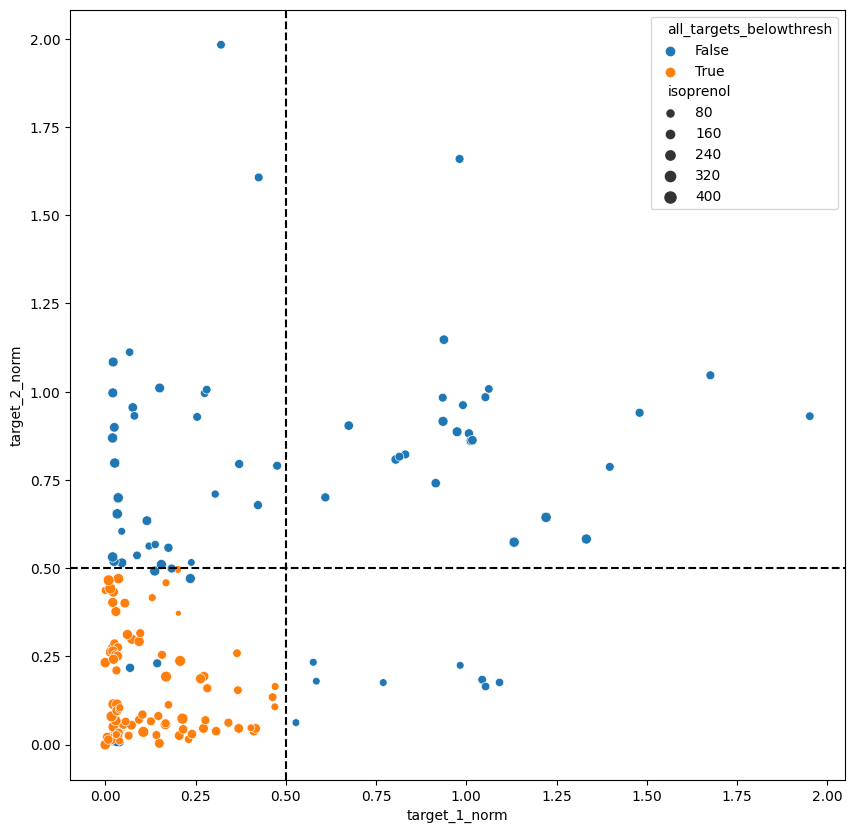

In [66]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(df_target, x = 'target_1_norm', y = 'target_2_norm', size = 'isoprenol', hue = 'all_targets_belowthresh')
ax.axhline(TARGET_THRESH, color = 'k', linestyle = '--')
ax.axvline(TARGET_THRESH, color = 'k', linestyle = '--')

In [67]:
df_target

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_3_norm,target_1_subtract,target_2_subtract,target_3_subtract,has_missing_control,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,all_targets_belowthresh
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288,3,173.9811,4446120.70,0.513739,PP_0226,PP_0897,...,0.102347,-4.867011e+04,-1.794354e+07,-1.348799e+06,False,True,True,True,True,True
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192,3,268.6526,6229968.25,0.719859,PP_1319,PP_1457,...,0.208580,-1.043328e+06,-2.634598e+06,-2.200610e+06,False,True,True,False,True,False
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266,3,182.8489,5220820.10,0.603254,PP_2213,PP_2471,...,0.029203,NaN,-2.401294e+06,-1.525835e+06,True,True,False,True,True,False
3,PP_3123_PP_4862_PP_5186-R1,1,False,PP_3123_PP_4862_PP_5186,3,165.8082,5115224.20,0.591053,PP_3123,PP_4862,...,0.041266,-1.335743e+04,-1.881919e+06,-3.293232e+05,False,True,True,True,True,True
4,PP_2137_PP_4116_PP_4187-R1,1,False,PP_2137_PP_4116_PP_4187,3,222.7008,4544896.34,0.525153,PP_2137,PP_4116,...,0.930541,-1.745057e+06,-3.028896e+07,-3.351323e+06,False,True,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,PP_0437_PP_3365-R3,3,False,PP_0437_PP_3365,2,247.0341,7127629.18,0.823582,PP_0437,PP_3365,...,NaN,-7.872946e+04,-6.904771e+06,NaN,False,True,True,True,False,True
188,PP_1319_PP_4121_PP_4667-R3,3,False,PP_1319_PP_4121_PP_4667,3,208.5925,4714006.75,0.544693,PP_1319,PP_4121,...,0.058878,-9.824164e+05,-1.436887e+07,-1.372165e+07,False,True,True,True,True,True
189,PP_0814_PP_4192-R3,3,False,PP_0814_PP_4192,2,328.0977,1115565.50,0.128901,PP_0814,PP_4192,...,NaN,-3.053488e+05,-9.619024e+05,NaN,False,False,True,False,False,False
190,PP_0812_PP_4121-R3,3,False,PP_0812_PP_4121,2,294.9253,417101.16,0.048195,PP_0812,PP_4121,...,NaN,-4.949295e+05,-1.283208e+06,NaN,False,False,False,False,False,False


<Axes: xlabel='all_targets_belowthresh', ylabel='isoprenol'>

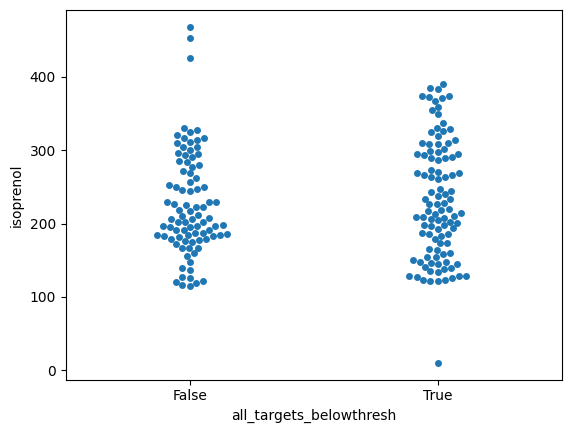

In [68]:
sns.swarmplot(df_target, y = 'isoprenol', x = 'all_targets_belowthresh')

In [69]:
df_target_grouped = df_target[['line_name_norep','all_targets_belowthresh']].groupby('line_name_norep').mean()
df_target_grouped['all_targets_belowthresh'] = df_target_grouped['all_targets_belowthresh'].apply(
    lambda x: True if x == 1 else False)


In [70]:
df_target_grouped.loc['Control','all_targets_belowthresh']


True

In [71]:
print(f'There are N = {df_target_grouped["all_targets_belowthresh"].sum()} strains with all targets below threshold')

There are N = 26 strains with all targets below threshold


In [72]:
df_target['all_reps_belowthresh'] = df_target['line_name_norep'].apply(lambda x: df_target_grouped.loc[x, 'all_targets_belowthresh'])

<Axes: xlabel='all_reps_belowthresh', ylabel='isoprenol'>

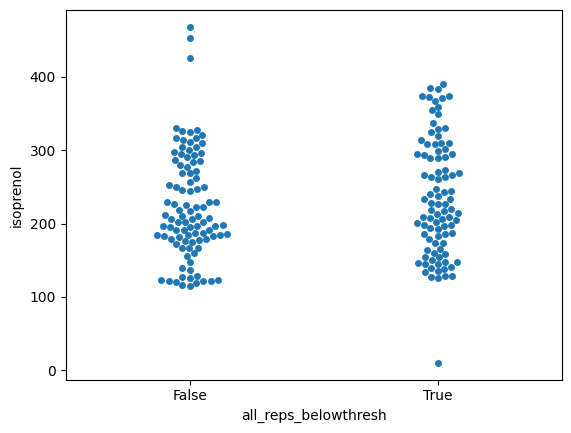

In [73]:
sns.swarmplot(df_target, y = 'isoprenol', x = 'all_reps_belowthresh')

### 3.4 Apply filters to strains based on target expression, dcas9 expression, and missing controls

In [74]:
df_target['to_keep'] = (df_target['all_reps_belowthresh'] | df_target['has_missing_control']) & df_target['above_dcas9_thresh']

In [75]:
df_target

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_2_subtract,target_3_subtract,has_missing_control,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,all_targets_belowthresh,all_reps_belowthresh,to_keep
0,PP_0226_PP_0897_PP_5288-R1,1,False,PP_0226_PP_0897_PP_5288,3,173.9811,4446120.70,0.513739,PP_0226,PP_0897,...,-1.794354e+07,-1.348799e+06,False,True,True,True,True,True,True,True
1,PP_1319_PP_1457_PP_4192-R1,1,False,PP_1319_PP_1457_PP_4192,3,268.6526,6229968.25,0.719859,PP_1319,PP_1457,...,-2.634598e+06,-2.200610e+06,False,True,True,False,True,False,False,False
2,PP_2213_PP_2471_PP_4266-R1,1,False,PP_2213_PP_2471_PP_4266,3,182.8489,5220820.10,0.603254,PP_2213,PP_2471,...,-2.401294e+06,-1.525835e+06,True,True,False,True,True,False,False,True
3,PP_3123_PP_4862_PP_5186-R1,1,False,PP_3123_PP_4862_PP_5186,3,165.8082,5115224.20,0.591053,PP_3123,PP_4862,...,-1.881919e+06,-3.293232e+05,False,True,True,True,True,True,True,True
4,PP_2137_PP_4116_PP_4187-R1,1,False,PP_2137_PP_4116_PP_4187,3,222.7008,4544896.34,0.525153,PP_2137,PP_4116,...,-3.028896e+07,-3.351323e+06,False,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,PP_0437_PP_3365-R3,3,False,PP_0437_PP_3365,2,247.0341,7127629.18,0.823582,PP_0437,PP_3365,...,-6.904771e+06,NaN,False,True,True,True,False,True,True,True
188,PP_1319_PP_4121_PP_4667-R3,3,False,PP_1319_PP_4121_PP_4667,3,208.5925,4714006.75,0.544693,PP_1319,PP_4121,...,-1.436887e+07,-1.372165e+07,False,True,True,True,True,True,True,True
189,PP_0814_PP_4192-R3,3,False,PP_0814_PP_4192,2,328.0977,1115565.50,0.128901,PP_0814,PP_4192,...,-9.619024e+05,NaN,False,False,True,False,False,False,False,False
190,PP_0812_PP_4121-R3,3,False,PP_0812_PP_4121,2,294.9253,417101.16,0.048195,PP_0812,PP_4121,...,-1.283208e+06,NaN,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Titer by final filter - dCas9 thresh = 0.25 - target thresh = 0.5')

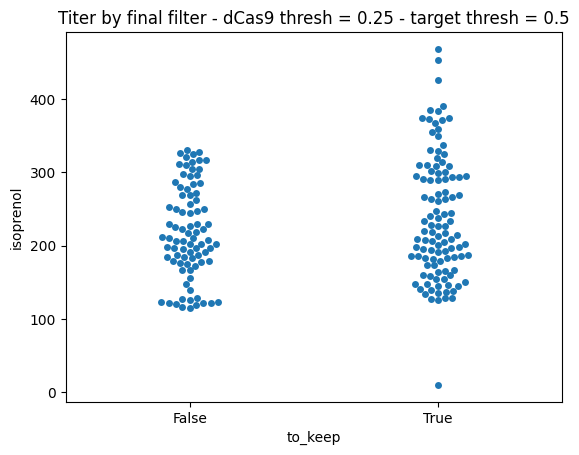

In [76]:
sns.swarmplot(df_target, x = 'to_keep', y = 'isoprenol')
plt.title(f'Titer by final filter - dCas9 thresh = {DCAS9_THRESH} - target thresh = {TARGET_THRESH}')

Save csv with the lines to keep

In [77]:
lines_to_keep_fname = f'filtered_lines_df_dcas9thresh_{DCAS9_THRESH}_targetthresh_{TARGET_THRESH}.csv'
df_target.loc[df_target['to_keep'], ['Line Name', 'line_name_norep','to_keep']].to_csv(lines_to_keep_fname)

In [78]:
len(df_target.loc[df_target['to_keep'], 'line_name_norep'].unique())

31

In [79]:
len(df_target.loc[~df_target['to_keep'], 'line_name_norep'].unique())

27

## 4. Plot

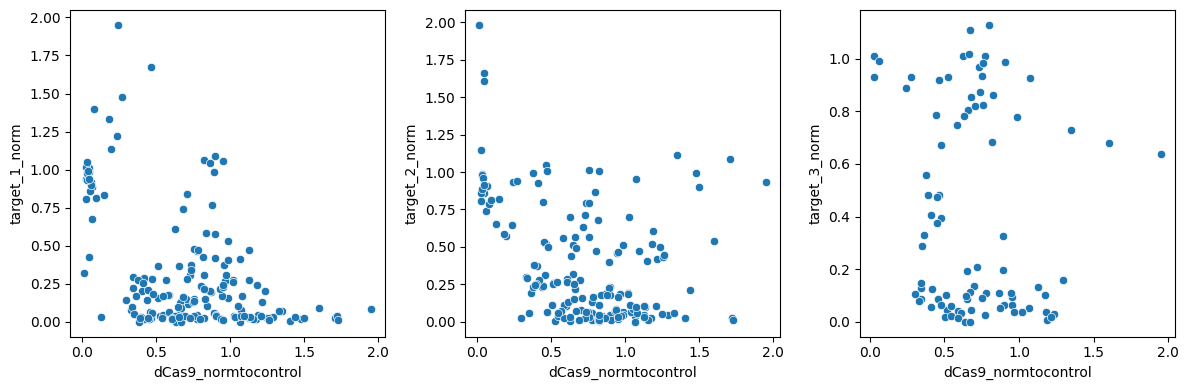

In [80]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4))
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_1_norm', ax = ax[0])
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_2_norm', ax = ax[1])
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_3_norm', ax = ax[2])
fig.tight_layout()

In [81]:
df_target['above_dcas9_thresh']

0       True
1       True
2       True
3       True
4       True
       ...  
187     True
188     True
189    False
190    False
191     True
Name: above_dcas9_thresh, Length: 192, dtype: bool

In [82]:
df_target[~df_target['above_dcas9_thresh']]

,Line Name,rep,is_control,line_name_norep,number_of_grna,isoprenol,dCas9,dCas9_normtocontrol,target_1,target_2,...,target_2_subtract,target_3_subtract,has_missing_control,above_dcas9_thresh,target_1_belowthresh,target_2_belowthresh,target_3_belowthresh,all_targets_belowthresh,all_reps_belowthresh,to_keep
6,PP_0813_PP_1769_PP_4191-R1,1,False,PP_0813_PP_1769_PP_4191,3,249.9867,271325.88,0.031351,PP_0813,PP_1769,...,-6.360248e+05,-2.319715e+06,False,False,False,False,False,False,False,False
14,PP_0813_PP_1769_PP_4191-R2,2,False,PP_0813_PP_1769_PP_4191,3,252.3807,263969.58,0.030501,PP_0813,PP_1769,...,4.888249e+05,3.612947e+05,False,False,False,False,False,False,False,False
22,PP_0813_PP_1769_PP_4191-R3,3,False,PP_0813_PP_1769_PP_4191,3,244.7739,531245.40,0.061384,PP_0813,PP_1769,...,-8.585088e+05,-2.820573e+05,False,False,False,False,False,False,False,False
32,PP_0751_PP_1620_PP_4678-R2,2,False,PP_0751_PP_1620_PP_4678,3,179.5294,2098360.44,0.242461,PP_0751,PP_1620,...,-2.512085e+04,-6.315378e+06,False,False,False,False,False,False,False,False
78,PP_0814_PP_4192-R4,4,False,PP_0814_PP_4192,2,324.9870,2044418.70,0.236228,PP_0814,PP_4192,...,-9.897009e+05,NaN,False,False,False,False,False,False,False,False
86,PP_0814_PP_4192-R5,5,False,PP_0814_PP_4192,2,316.4488,1694970.88,0.195850,PP_0814,PP_4192,...,-1.184783e+06,NaN,False,False,False,False,False,False,False,False
94,PP_0814_PP_4192-R6,6,False,PP_0814_PP_4192,2,309.2832,1613251.70,0.186408,PP_0814,PP_4192,...,-1.160115e+06,NaN,False,False,False,False,False,False,False,False
97,PP_0774_PP_1769-R1,1,False,PP_0774_PP_1769,2,202.4628,416522.82,0.048128,PP_0774,PP_1769,...,2.185908e+06,NaN,False,False,False,False,False,False,False,False
100,PP_2339_PP_4186-R1,1,False,PP_2339_PP_4186,2,229.6977,366434.88,0.042341,PP_2339,PP_4186,...,-1.263879e+07,NaN,False,False,False,False,False,False,False,False
103,PP_1607_PP_4550-R1,1,False,PP_1607_PP_4550,2,175.6127,589311.05,0.068094,PP_1607,PP_4550,...,NaN,NaN,True,False,False,False,False,False,False,False


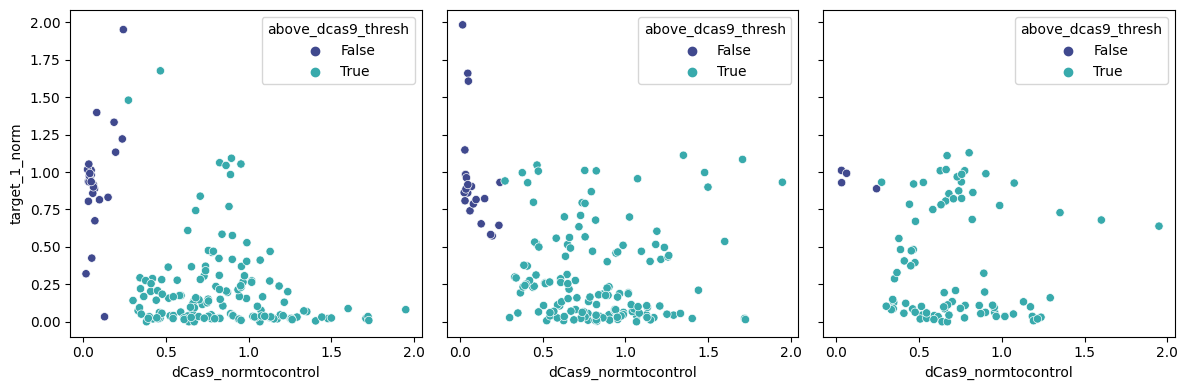

In [83]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_1_norm', hue = 'above_dcas9_thresh', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_2_norm', hue = 'above_dcas9_thresh', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_3_norm', hue = 'above_dcas9_thresh', ax = ax[2], palette = 'mako')
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/dCas9_vs_target_normalized_scatter.png')

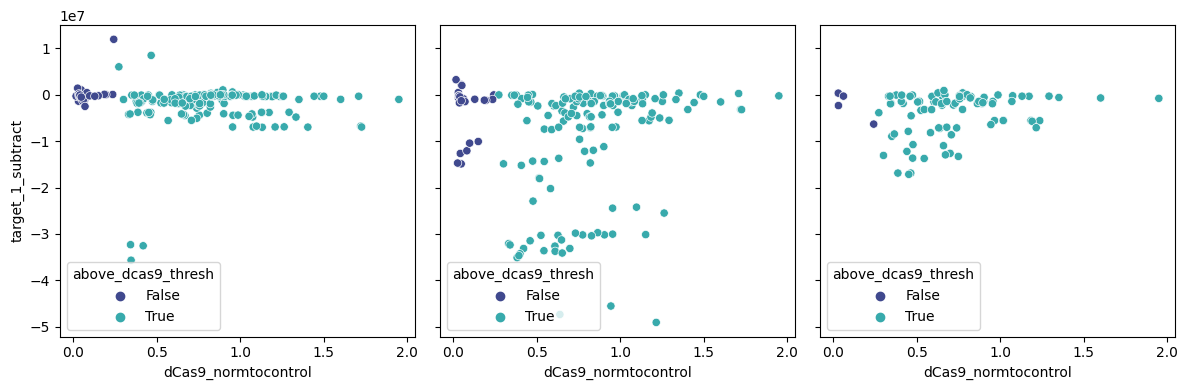

In [84]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_1_subtract', hue = 'above_dcas9_thresh', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_2_subtract', hue = 'above_dcas9_thresh', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'dCas9_normtocontrol', y = 'target_3_subtract', hue = 'above_dcas9_thresh', ax = ax[2], palette = 'mako')

fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/dCas9_vs_target_subtracted_scatter.png')

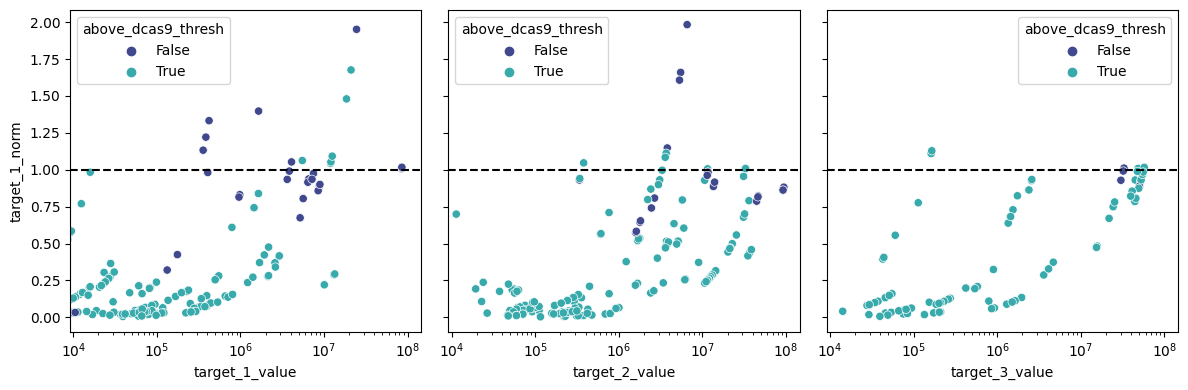

In [85]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'target_1_value', y = 'target_1_norm', hue = 'above_dcas9_thresh', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'target_2_value', y = 'target_2_norm', hue = 'above_dcas9_thresh', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'target_3_value', y = 'target_3_norm', hue = 'above_dcas9_thresh', ax = ax[2], palette = 'mako')
[axis.set_xscale('log') for axis in ax]
[axis.axhline(1, color = 'k', linestyle = '--') for axis in ax]
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/target_vs_target_normalized_scatter.png')

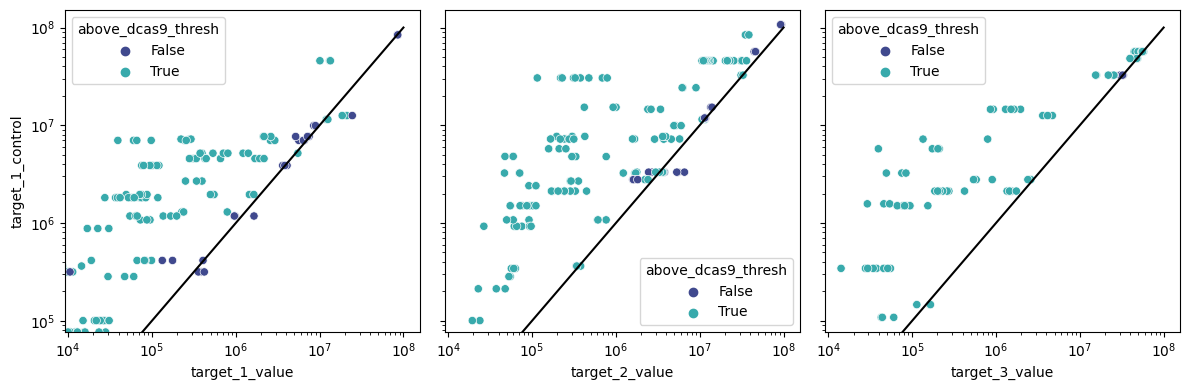

In [86]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (12,4), sharex=True, sharey=True)
sns.scatterplot(df_target, x = 'target_1_value', y = 'target_1_control', hue = 'above_dcas9_thresh', ax = ax[0], palette = 'mako')
sns.scatterplot(df_target, x = 'target_2_value', y = 'target_2_control', hue = 'above_dcas9_thresh', ax = ax[1], palette = 'mako')
sns.scatterplot(df_target, x = 'target_3_value', y = 'target_3_control', hue = 'above_dcas9_thresh', ax = ax[2], palette = 'mako')
[axis.set_xscale('log') for axis in ax]
[axis.set_yscale('log') for axis in ax]
[axis.plot([0,1e8], [0, 1e8], 'k') for axis in ax]
fig.tight_layout()
# fig.savefig('dbtl1_proteomics_analysis/target_vs_target_normalized_scatter.png')

Add normalized isoprenol to plot

In [87]:
mean_control_isoprenol = np.mean(df_target.loc[df_target['is_control'], 'isoprenol'])
df_target['isoprenol_norm'] = df_target['isoprenol']/mean_control_isoprenol

In [88]:
df_target['isoprenol_norm'].max()

3.0331568751860667

In [89]:
df_bar = pd.melt(df_target[~df_target['above_dcas9_thresh']].sort_values(by= 'Line Name'), id_vars = ['Line Name', 'line_name_norep'], value_vars=['target_1_norm', 'target_2_norm', 'dCas9_normtocontrol'])
df_bar

,Line Name,line_name_norep,variable,value
0,PP_0751_PP_1620_PP_4678-R2,PP_0751_PP_1620_PP_4678,target_1_norm,1.951392
1,PP_0774_PP_1769-R1,PP_0774_PP_1769,target_1_norm,0.981325
2,PP_0774_PP_1769-R2,PP_0774_PP_1769,target_1_norm,0.320556
3,PP_0774_PP_1769-R3,PP_0774_PP_1769,target_1_norm,0.424999
4,PP_0812_PP_4121-R1,PP_0812_PP_4121,target_1_norm,0.674404
...,...,...,...,...
73,PP_1607_PP_4550-R2,PP_1607_PP_4550,dCas9_normtocontrol,0.057835
74,PP_1607_PP_4550-R3,PP_1607_PP_4550,dCas9_normtocontrol,0.061724
75,PP_2339_PP_4186-R1,PP_2339_PP_4186,dCas9_normtocontrol,0.042341
76,PP_2339_PP_4186-R2,PP_2339_PP_4186,dCas9_normtocontrol,0.047722


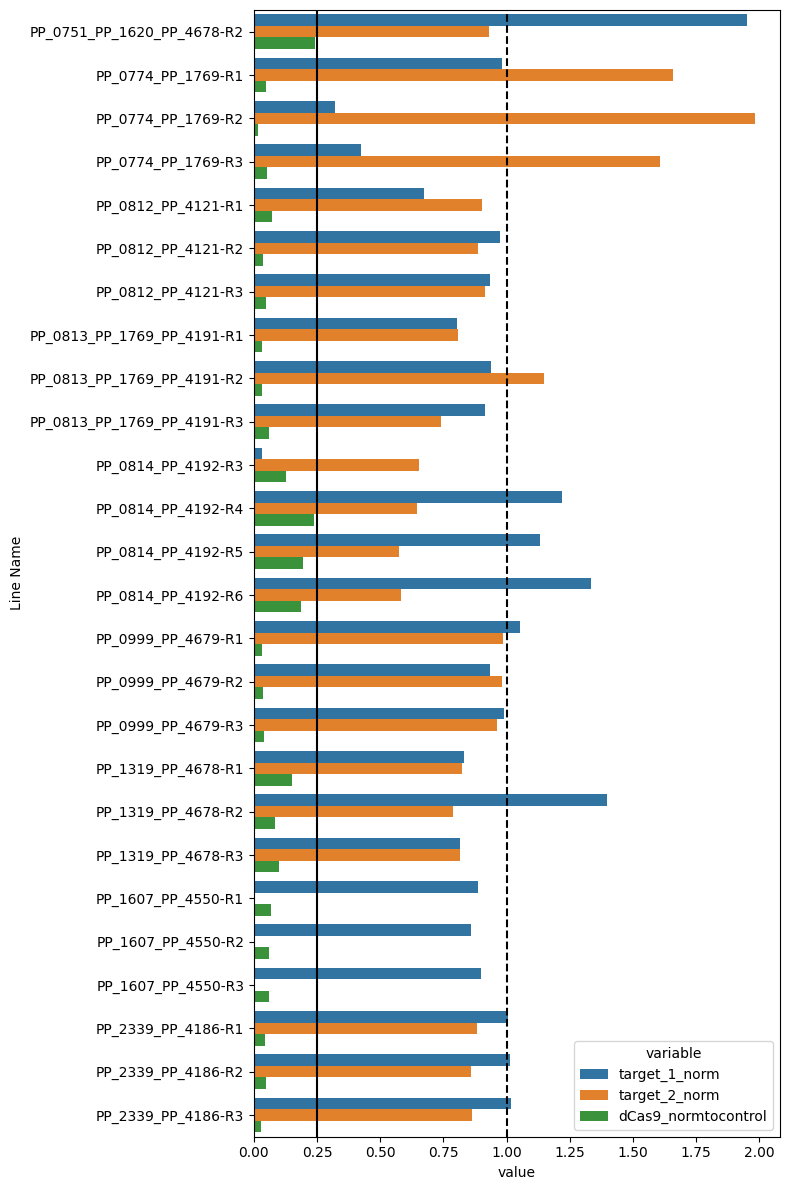

In [90]:
fig, ax = plt.subplots(figsize = (8,12))
sns.barplot(df_bar, y = 'Line Name', x = 'value', hue = 'variable', ax = ax)
ax.axvline(0.25, color = 'k')
ax.axvline(1, color = 'k', linestyle = '--')
# fig.legend(['target 1 norm', 'dCas9 norm', 'target 2 norm', 'dCas9 threshold', '1'])
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/bar_graph_for_failing_strains_sortbyname.png')

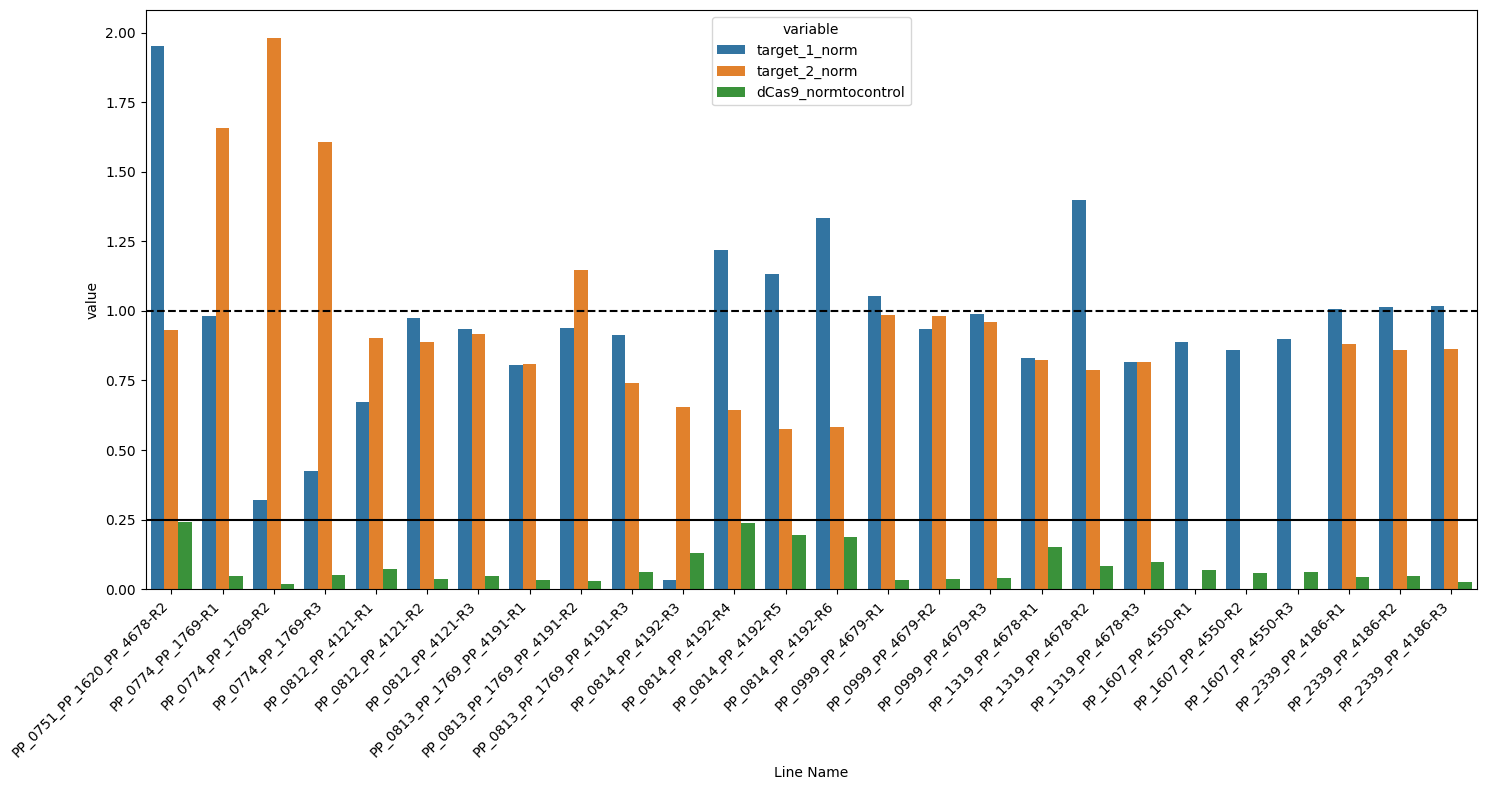

In [91]:
fig, ax = plt.subplots(figsize = (15,8))
bp = sns.barplot(df_bar, x = 'Line Name', y = 'value', hue = 'variable', ax = ax)
ax.axhline(0.25, color = 'k')
ax.axhline(1, color = 'k', linestyle = '--')
bp.set_xticklabels(bp.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='right')
# fig.legend(['target 1 norm', 'dCas9 norm', 'target 2 norm', 'dCas9 threshold', '1'])
fig.tight_layout()
fig.savefig('dbtl1_proteomics_analysis/bar_graph_for_failing_strains_sortbyname_rotate.png')

<Axes: xlabel='above_dcas9_thresh', ylabel='isoprenol_norm'>

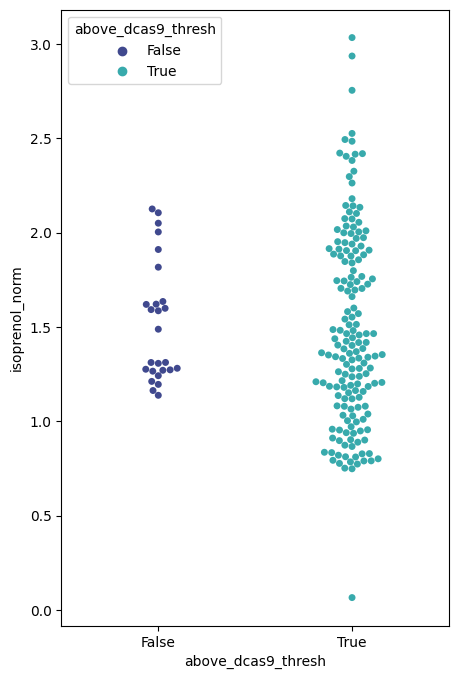

In [92]:
fig, ax = plt.subplots(figsize = (5,8))
sns.swarmplot(df_target, y = 'isoprenol_norm', x = 'above_dcas9_thresh', hue = 'above_dcas9_thresh', palette= 'mako')

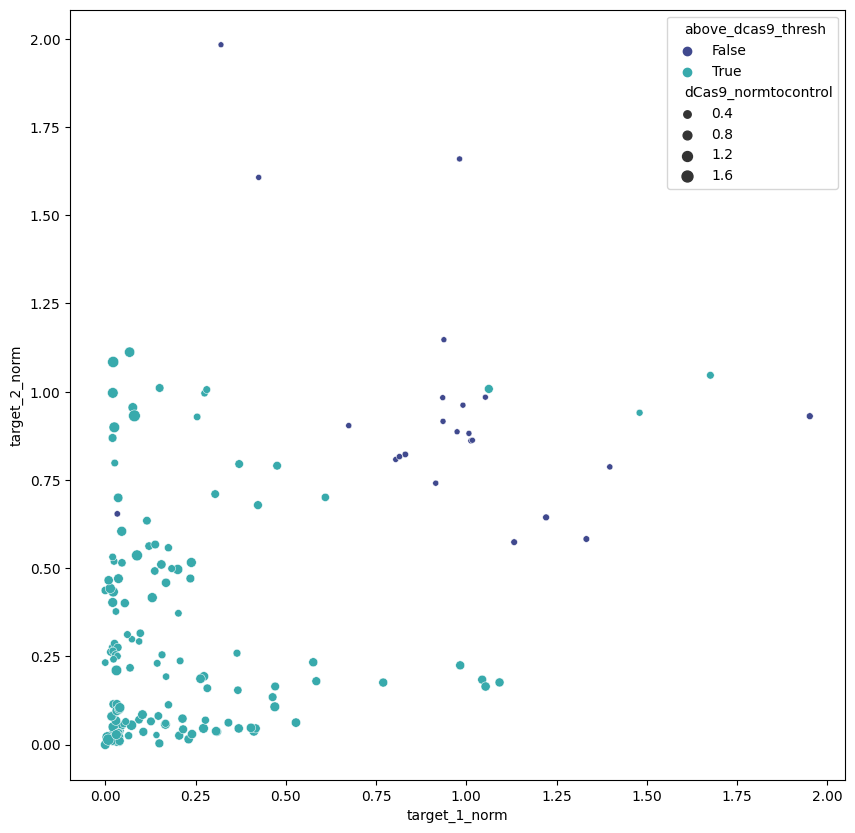

In [93]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(df_target, x = 'target_1_norm', y = 'target_2_norm', size = 'dCas9_normtocontrol', hue = 'above_dcas9_thresh', palette = 'mako')
fig.savefig('Crispri_dcas9_eval.png')

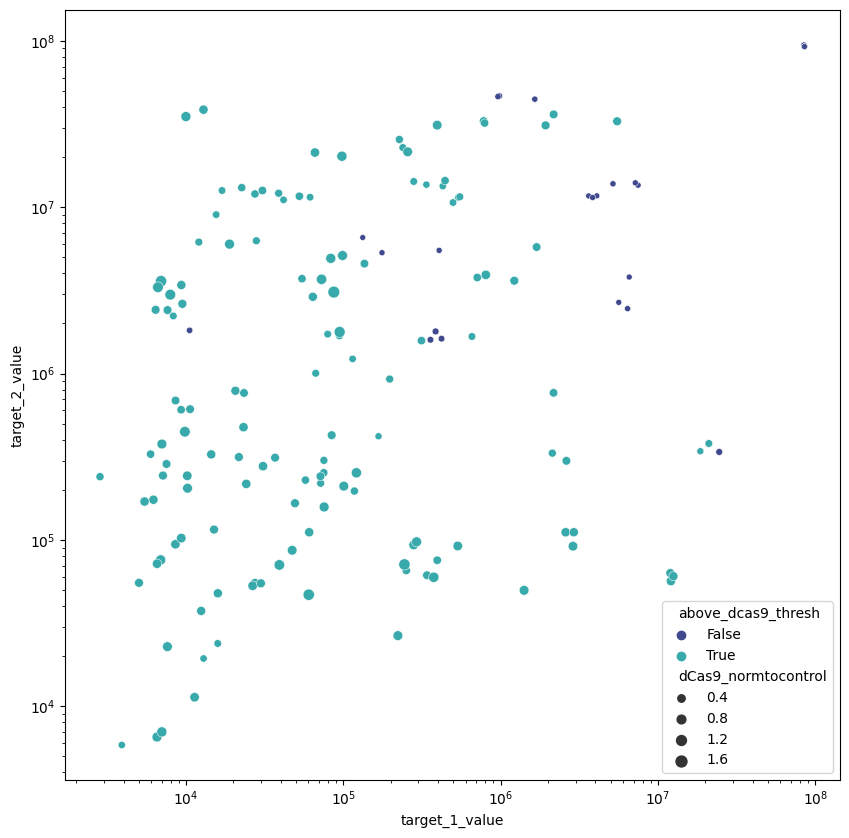

In [94]:
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(df_target, x = 'target_1_value', y = 'target_2_value', size = 'dCas9_normtocontrol', hue = 'above_dcas9_thresh', palette = 'mako')
ax.set_xscale('log')
ax.set_yscale('log')

<Axes: xlabel='norm_value', ylabel='Count'>

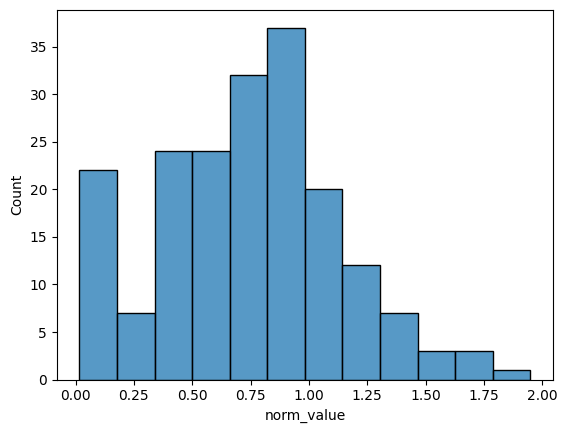

In [95]:
sns.histplot(df2[df2['Formal Type'] == 'dCas9'], x = 'norm_value')